In [2]:
# Built-in modules
import math
 
# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import grover_operator, MCMTGate, ZGate
from qiskit.visualization import plot_distribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

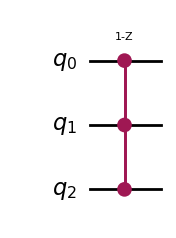

In [3]:
# MCMTGate的用法

mcmt_ex = QuantumCircuit(3)
mcmt_ex.compose(MCMTGate(ZGate(), 3 - 1, 1), inplace=True)
mcmt_ex.draw(output="mpl")

In [4]:
def grover_oracle(marked_states):
    """
    对多个输入的目标量子比特进行相位翻转
    假设所有的目标量子比特的长度相同
    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    num_qubits = len(marked_states[0])
 
    qc = QuantumCircuit(num_qubits)
    for target in marked_states:
        # Flip target bitstring to match Qiskit bit-ordering
        rev_target = target[::-1]
        # 找到所有的0比特的位置，然后将其翻转为1，为方便之后使用MCMTGate-Z进行相位翻转
        zero_inds = [
            ind for ind in range(num_qubits) if rev_target.startswith("0", ind)
        ]
        print(zero_inds)
        qc.x(zero_inds)
        qc.compose(MCMTGate(ZGate(), num_qubits - 1, 1), inplace=True)
        # 在恢复0
        qc.x(zero_inds)
    return qc

[0]


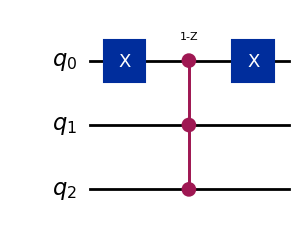

In [11]:
marked_states = ["110"]
# 实例化一个预言机
oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

grover_operator参数：
1. oracle (必需)，相位翻转预言机
2. state_preparation (可选)，在标准的 Grover 算法中，A 就是对所有量子比特施加哈达玛门 (H)，从而创建均匀叠加态
3. zero_reflection (可选)：均值倒反操作的矩阵
4. reflection_qubits (可选)，默认值: None (表示对所有量子比特进行反射)
作用: 指定 zero_reflection 算子作用在哪些量子比特上。这在你处理一个大型电路，但 Grover 操作只作用于其中一部分量子比特时非常有用。
示例: 如果你的电路有 5 个量子比特，但 Oracle 只标记前 3 个量子比特定义的状态，那么你可以设置 reflection_qubits=[0, 1, 2]，这样零反射就只在前 3 个量子比特上定义。

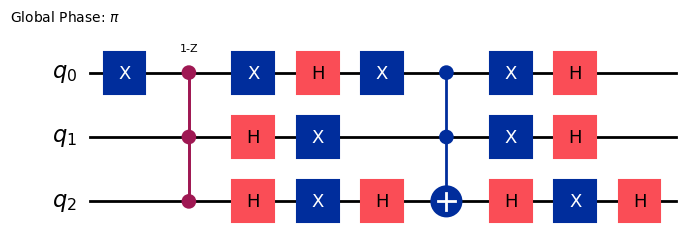

In [12]:
# 最标准的流程
grover_op = grover_operator(oracle)
grover_op.decompose(reps=0).draw(output="mpl", style="iqp")

最佳重复次数？？

开始构建一个从初态经过H门叠加后，再次经过预言机翻转，和均值倒反(添加最佳次数个)的完整操作

2


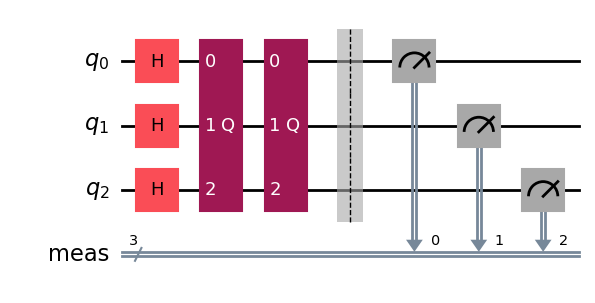

In [13]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

print(optimal_num_iterations)
qc = QuantumCircuit(grover_op.num_qubits)
# 最标准的流程，state_preparation就是H
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl")

我们已经定义了抽象的量子电路，但我们需要根据我们实际想要使用的量子计算机的固有门来重写它。我们还需要指定应该使用量子计算机上的哪些量子比特。出于这些原因以及其他原因，我们现在必须转换我们的电路。首先，让我们指定我们希望使用的量子计算机。

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# To run on hardware, select the backend with the fewest number of jobs in the queue，但是由于各种原因，无法申请账户
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
backend.name

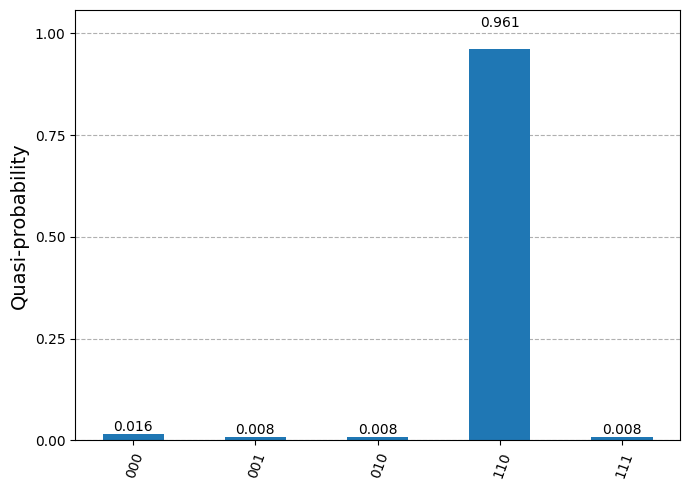

In [15]:
from qiskit.primitives import StatevectorSampler as Sampler
# 申请不到实机就用本地模拟器
sample = Sampler()
job = sample.run([qc], shots=128)
job_result = job.result()
dist = job_result[0].data.meas.get_counts()
plot_distribution(dist)

更改state_preparation：

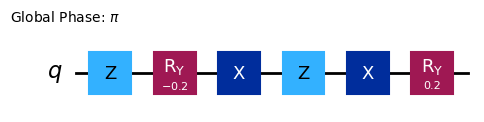

In [14]:
oracle = QuantumCircuit(1)  # 定义新的预言机
oracle.z(0)  # the qubit state |1> is the good state
state_preparation = QuantumCircuit(1)
state_preparation.ry(0.2, 0)  # 不是H
grover_op = grover_operator(oracle, state_preparation)
grover_op.draw("mpl")

我们还可以标记零反射应该作用于哪些量子位。这在某些量子位仅用作临时空间但不应影响预言机的情况下很有用：

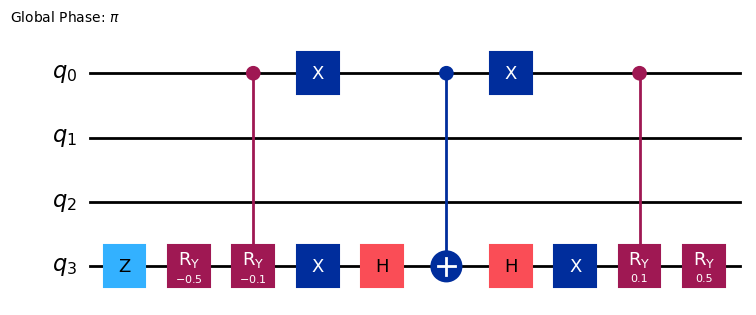

In [15]:
oracle = QuantumCircuit(4)
oracle.z(3)
# 只在0,3上应用均值倒反
reflection_qubits = [0, 3]
state_preparation = QuantumCircuit(4)
state_preparation.cry(0.1, 0, 3)
state_preparation.ry(0.5, 3)
grover_op = grover_operator(oracle, state_preparation, reflection_qubits=reflection_qubits)
grover_op.draw("mpl")